## Training a Document Denoiser Model with AutoEncoders


In [69]:
import keras
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import os
import ntpath
from glob import glob
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Flatten, Dropout, SpatialDropout2D, Conv2D, UpSampling2D, MaxPooling2D, add, concatenate, Input, BatchNormalization
from keras.backend import set_image_data_format
from keras.utils import plot_model

## Download Dataset

Download the dataset from [kaggle (denoising dirty documents)](https://www.kaggle.com/c/denoising-dirty-documents/data). You will need to be logged in to be able to download the data.

Once downloaded run the following commands

In [ ]:
!unzip denoising-dirty-documents.zip && rm denoising-dirty-documents.zip
!mv denoising-dirty-documents/*.zip . && rm -rf denoising-dirty-documents
!unzip '*.zip' > /dev/null && rm *.zip

## Define the Data Generator

Include data augmentation because the dataset is rather small.

In [2]:
x_dirty = sorted(glob("train/*.png"))
x_cleaned = sorted(glob("train_cleaned/*.png"))
x_test = sorted(glob("test/*.png"))
input_shape = (260, 540)
height = input_shape[0]
width = input_shape[1]

In [3]:
x_train, x_valid, y_train, y_valid = train_test_split(x_dirty, x_cleaned, test_size=0.20)

In [4]:
set_image_data_format("channels_last")

In [5]:
def model_train_generator(x_train, y_train, epochs, batch_size, resize_shape):
    white_fill = 1.0
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        fill_mode="constant",
        cval=white_fill,
        horizontal_flip=True,
        vertical_flip=True,
    )
    
    for _ in range(epochs):
        for x_file, y_file in zip(x_train, y_train):
            x_img = cv2.imread(x_file, cv2.IMREAD_GRAYSCALE) / 255.0
            y_img = cv2.imread(y_file, cv2.IMREAD_GRAYSCALE) / 255.0
            
            xs = []
            ys = []
            for i in range(batch_size):
                if i == 0:
                    x = x_img
                    y = y_img
                else:
                    params = datagen.get_random_transform(img_shape=x_img.shape)
                    x = datagen.apply_transform(np.expand_dims(x_img, 2), params)
                    y = datagen.apply_transform(np.expand_dims(y_img, 2), params)
                x = cv2.resize(x, resize_shape[::-1], interpolation=cv2.INTER_AREA)
                y = cv2.resize(y, resize_shape[::-1], interpolation=cv2.INTER_AREA)
                x = np.expand_dims(x, 2)
                y = np.expand_dims(y, 2)
                xs.append(x)
                ys.append(y)
            xs_imgs = np.array(xs)
            ys_imgs = np.array(ys)
            yield (xs_imgs, ys_imgs)

def model_valid_generator(x_valid, y_valid, epochs, resize_shape):
    xs = []
    ys = []
    for x_file, y_file in zip(x_valid, y_valid):
        x_img = cv2.imread(x_file, cv2.IMREAD_GRAYSCALE) / 255.0
        y_img = cv2.imread(y_file, cv2.IMREAD_GRAYSCALE) / 255.0
        x = cv2.resize(x_img, resize_shape[::-1], interpolation=cv2.INTER_AREA)
        y = cv2.resize(y_img, resize_shape[::-1], interpolation=cv2.INTER_AREA)
        x = np.expand_dims(x, 2)
        x = np.expand_dims(x, 0)
        y = np.expand_dims(y, 2)
        y = np.expand_dims(y, 0)
        xs.append(x)
        ys.append(y)
    
    for _ in range(epochs):
        for xs_img, ys_img in zip(xs, ys):
            yield (xs_img, ys_img)

## Create the Model

In [6]:
def create_encoder(input_shape):
    inp = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), 
                     input_shape=input_shape, activation="relu", padding="same")(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), 
                     activation="relu", padding="same")(x)
    x = BatchNormalization()(x)

    return inp, x

In [7]:
def create_decoder(inp):
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu",
                    padding="same")(inp)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x)
    
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), 
                     activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), 
                     activation="sigmoid", padding="same")(x)
    x = BatchNormalization()(x)
    
    return inp, x

In [8]:
def create_autoencoder(input_shape):
    enc_inp, encoder = create_encoder(input_shape)
    dec_inp, autoencoder = create_decoder(encoder)
    model = Model(inputs=[enc_inp], outputs=[autoencoder], name='AutoEncoder')
    
    return model

In [9]:
model = create_autoencoder((height, width, 1))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 260, 540, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 260, 540, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 260, 540, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 130, 270, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 270, 32)      18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 130, 270, 32)      128       
_______________________________________

In [10]:
model.compile(optimizer='adam', loss='mse')
epochs = 20
batch_size = 8
samples = len(x_train)
validation_samples = len(x_valid)
train_generator = model_train_generator(x_train, y_train, epochs=epochs, batch_size=batch_size, resize_shape=(height, width))
valid_generator = model_valid_generator(x_valid, y_valid, epochs=epochs, resize_shape=(height, width))

## Train the AutoEncoder Model

In [11]:
hist_obj = model.fit_generator(train_generator, validation_data=valid_generator, validation_steps=validation_samples, steps_per_epoch=samples, epochs=epochs, shuffle=True) 


Epoch 1/20
115/115 [==============================] - 49s 429ms/step - loss: 1.2062 - val_loss: 0.1817
Epoch 2/20
115/115 [==============================] - 43s 373ms/step - loss: 0.5792 - val_loss: 0.1720
Epoch 3/20
115/115 [==============================] - 43s 373ms/step - loss: 0.4297 - val_loss: 0.1399
Epoch 4/20
115/115 [==============================] - 43s 375ms/step - loss: 0.3160 - val_loss: 0.1023
Epoch 5/20
115/115 [==============================] - 44s 385ms/step - loss: 0.2276 - val_loss: 0.0609
Epoch 6/20
115/115 [==============================] - 44s 379ms/step - loss: 0.1599 - val_loss: 0.0292
Epoch 7/20
115/115 [==============================] - 43s 376ms/step - loss: 0.1091 - val_loss: 0.0112
Epoch 8/20
115/115 [==============================] - 43s 376ms/step - loss: 0.0730 - val_loss: 0.0074
Epoch 9/20
115/115 [==============================] - 44s 381ms/step - loss: 0.0473 - val_loss: 0.0055
Epoch 10/20
115/115 [==============================] - 45s 393ms/step - 

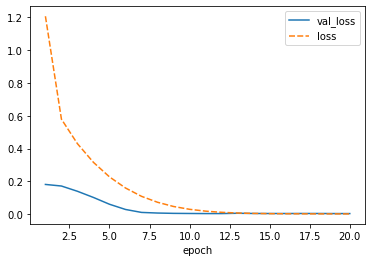

In [29]:
hist_pd = pd.DataFrame(hist_obj.history, index=np.arange(1, len(hist_obj.history['loss'])+1))
hist_pd.index.name = 'epoch'
sns.lineplot(data=hist_pd)

In [30]:
model_name = "model.h5"

In [31]:
model.save(model_name)

In [32]:
# model = load_model(model_name)

## Testing Accuracy

In [33]:
def test_generator(x_test, resize_shape):
    for sample in x_test:
        img = cv2.imread(sample, cv2.IMREAD_GRAYSCALE) / 255.0
        res_img = cv2.resize(img, resize_shape[::-1], interpolation=cv2.INTER_AREA)
        res_img = np.expand_dims(res_img, 0)
        res_img = np.expand_dims(res_img, 3)
        np_img = np.array(res_img)
        yield (np_img, np_img)

In [34]:
steps = len(x_test)
test_gen = test_generator(x_test, input_shape)
loss = model.evaluate_generator(test_gen, steps=steps)
print("MSE Loss:", loss)

MSE Loss: 0.07084273546934128


## Sample Prediction

In [35]:
img = cv2.imread(x_test[0], cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, input_shape[::-1], interpolation=cv2.INTER_AREA)

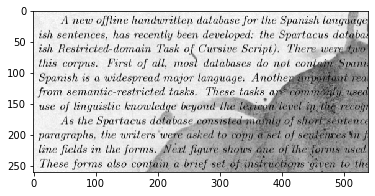

In [36]:
imshow(img, cmap='gray')

In [70]:
def make_prediction(img):
    processed = img / 255.0
    processed = np.expand_dims(processed, 0)
    processed = np.expand_dims(processed, 3)
    pred = model.predict(processed)
    pred = np.squeeze(pred, 3)
    pred = np.squeeze(pred, 0)
    out_img = pred * 255
    out_img[out_img > 255.0] = 255.0
    out_img = out_img.astype(np.uint8)
    return out_img

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [65]:
pred = make_prediction(img)

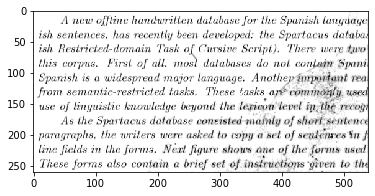

In [66]:
imshow(pred, cmap='gray')

In [73]:
output_dir = 'test_preds'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for x_test_file in x_test:
    img = cv2.imread(x_test_file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, input_shape[::-1], interpolation=cv2.INTER_AREA)
    pred = make_prediction(img)
    filename = path_leaf(x_test_file)
    filepath = os.path.join(output_dir, filename)
    cv2.imwrite(filepath, pred)